# <b>Task 3</b>: Customer Segmentation / Clustering

Perform <b>customer segmentation</b> using clustering techniques. Use both <b>profile information</b>
(from <i>Customers.csv</i>) and transaction information (from <i>Transactions.csv</i>).
- You have the flexibility to choose any clustering algorithm and any number of clusters in
between(2 and 10)
- Calculate clustering metrics, including the <b>DB Index(Evaluation will be done on this)</b>.
- Visualise your clusters using relevant plots.


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score 
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

## Loading the Dataset

In [2]:
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")

In [3]:
customers.head()

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [4]:
transactions.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


## Data Preprocessing

### Adding RFM features and Selecting the required features

In [5]:
from sklearn.preprocessing import LabelEncoder

# Convert SignupDate and TransactionDate to datetime
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

# Add Recency, Frequency, and Monetary features
transactions = transactions.groupby('CustomerID').agg({
    'TransactionDate': lambda x: (pd.to_datetime('today') - pd.to_datetime(x.max())).days,
    'TotalValue': 'sum', 
    'TransactionID': 'count' 
}).rename(columns={
    'TotalValue': 'Monetary',
    'TransactionID': 'Frequency',
    'TransactionDate': 'Recency'
}).reset_index()

# Merge with the customer profile data
customer_data = customers.merge(transactions, on="CustomerID", how="left")

# Calculate customer tenure
customer_data['Tenure'] = (pd.to_datetime('today') - customer_data['SignupDate']).dt.days

# Select features for clustering
features = ['Region', 'Tenure', 'Recency', 'Frequency', 'Monetary']

# One-hot encode the Region feature
customer_data = pd.get_dummies(customer_data[features], columns=['Region'])

In [6]:
print(customer_data.head())

   Tenure  Recency  Frequency  Monetary  Region_Asia  Region_Europe  \
0     933     87.0        5.0   3354.52        False          False   
1    1080     56.0        4.0   1862.74         True          False   
2     327    157.0        4.0   2725.38        False          False   
3     842     36.0        8.0   5354.88        False          False   
4     897     85.0        3.0   2034.24         True          False   

   Region_North America  Region_South America  
0                 False                  True  
1                 False                 False  
2                 False                  True  
3                 False                  True  
4                 False                 False  


### Handling missing values

In [7]:
customer_data.isnull().sum()

Tenure                  0
Recency                 1
Frequency               1
Monetary                1
Region_Asia             0
Region_Europe           0
Region_North America    0
Region_South America    0
dtype: int64

In [8]:
customer_data = customer_data.fillna(0)
customer_data.isnull().sum()

Tenure                  0
Recency                 0
Frequency               0
Monetary                0
Region_Asia             0
Region_Europe           0
Region_North America    0
Region_South America    0
dtype: int64

### Standardizing the data

In [9]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data)

In [10]:
print(scaled_features)

[[ 1.15288412 -0.25044626  0.         ... -0.57735027 -0.54653573
   1.54590766]
 [ 1.60559336 -0.68735308 -0.45129368 ... -0.57735027 -0.54653573
  -0.64686916]
 [-0.7133866   0.73611752 -0.45129368 ... -0.57735027 -0.54653573
   1.54590766]
 ...
 [ 1.56247819  0.15827302 -1.35388105 ...  1.73205081 -0.54653573
  -0.64686916]
 [ 0.70325454 -0.15178988 -0.45129368 ...  1.73205081 -0.54653573
  -0.64686916]
 [ 0.11812015 -0.80010323  0.         ... -0.57735027 -0.54653573
  -0.64686916]]


### Dimensionality Reduction

In [11]:
# Reduce dimensions using PCA
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(scaled_features)

In [12]:
# Visualize PCA output
import plotly.express as px

fig = px.scatter(x=reduced_features[:, 0], y=reduced_features[:, 1])
fig.update_traces(marker=dict(size=10, color='blue'))
fig.update_layout(title='PCA Reduced Features', xaxis_title='PCA Component 1', yaxis_title='PCA Component 2', width=800, height=600)
fig.show()

## Performing Cluster Evaluation with <b>K-Means</b> using the following metrics:

- Silhouette Scores
- <b>Davies-Bouldin(DB) Index</b>
- Elbow Method (Average Distortion)
- Elbow Method (Inertia)

In [40]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from scipy.spatial.distance import cdist

def comprehensive_cluster_validation(X, k_range=range(2, 11)):
    """
    Perform comprehensive cluster validation using multiple methods.
    
    Parameters:
    X : array-like
        Input data
    k_range : range
        Range of k values to test
    """
    # Store metrics
    silhouette_scores = []
    db_scores = []
    distortions = []
    inertias = []
    
    for k in k_range:
        # Fit KMeans
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        
        # Calculate metrics
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))
        db_scores.append(davies_bouldin_score(X, kmeans.labels_))
        distortions.append(sum(np.min(cdist(X, kmeans.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
        inertias.append(kmeans.inertia_)
    
    # Create subplots in plotly

    fig = make_subplots(rows=2, cols=2, subplot_titles=('Silhouette Score', 'Davies-Bouldin(DB) Index', 'Elbow Method (Average Distortion)', 'Elbow Method (Inertia)'))

    # Plot 1: Silhouette Score
    fig.add_trace(go.Scatter(x=list(k_range), y=silhouette_scores, mode='lines+markers', name='Silhouette'), row=1, col=1)
    fig.update_xaxes(title_text='Number of clusters', row=1, col=1)
    fig.update_yaxes(title_text='Score', row=1, col=1)

    # Plot 2: Davies-Bouldin Score
    fig.add_trace(go.Scatter(x=list(k_range), y=db_scores, mode='lines+markers', name='Davies-Bouldin(DB)'), row=1, col=2)
    fig.update_xaxes(title_text='Number of clusters', row=1, col=2)
    fig.update_yaxes(title_text='Score', row=1, col=2)

    # Plot 3: Elbow Method (Distortion)
    fig.add_trace(go.Scatter(x=list(k_range), y=distortions, mode='lines+markers', name='Distortion'), row=2, col=1)
    fig.update_xaxes(title_text='Number of clusters', row=2, col=1)
    fig.update_yaxes(title_text='Distortion', row=2, col=1)

    # Plot 4: Elbow Method (Inertia)
    fig.add_trace(go.Scatter(x=list(k_range), y=inertias, mode='lines+markers', name='Inertia'), row=2, col=2)
    fig.update_xaxes(title_text='Number of clusters', row=2, col=2)
    fig.update_yaxes(title_text='Inertia', row=2, col=2)

    fig.update_layout(title_text='Comprehensive Cluster Validation', height=800)
    fig.show()
    return fig, (silhouette_scores, db_scores, distortions, inertias)

def print_recommendations(k_range, metrics):
    """Print recommendations based on different metrics"""
    silhouette_scores, db_scores, distortions, inertias = metrics
    
    print("Recommendations based on different metrics:")
    print("-----------------------------------------")
    print(f"Silhouette Score (higher is better): Optimal k = {list(k_range)[np.argmax(silhouette_scores)]}")
    print(f"Davies-Bouldin(DB) Index (lower is better): Optimal k = {list(k_range)[np.argmin(db_scores)]}")
    
    # Calculate elbow points using second derivative
    def find_elbow(y):
        diffs = np.diff(y, 2)
        return np.argmax(diffs) + 2
    
    print(f"Elbow Method (Distortion): Suggested k = {list(k_range)[find_elbow(distortions)]}")
    print(f"Elbow Method (Inertia): Suggested k = {list(k_range)[find_elbow(inertias)]}")

In [41]:
cluster_range = range(2, 11)
fig, metrics = comprehensive_cluster_validation(reduced_features, cluster_range)

print_recommendations(cluster_range, metrics)

Recommendations based on different metrics:
-----------------------------------------
Silhouette Score (higher is better): Optimal k = 6
Davies-Bouldin(DB) Index (lower is better): Optimal k = 6
Elbow Method (Distortion): Suggested k = 4
Elbow Method (Inertia): Suggested k = 4


## Clustering for Optimal k = 6 (As per Silhouette Score and DB Index)

In [17]:
kmeans_6 = KMeans(n_clusters=6, init='k-means++', random_state=42)
kmeans_6.fit_predict(reduced_features)

# Evaluate clustering
silhouette_avg = silhouette_score(reduced_features, kmeans_6.labels_)
db_index = davies_bouldin_score(reduced_features, kmeans_6.labels_)

print(f"Silhouette Coefficient for n_clusters=6: {silhouette_avg:.4f}")
print(f"Davies-Bouldin Index for n_clusters=6: {db_index:.4f}")

Silhouette Coefficient for n_clusters=6: 0.3977
Davies-Bouldin Index for n_clusters=6: 0.7853


In [47]:
import plotly.express as px

fig = px.scatter(x=reduced_features[:, 0], y=reduced_features[:, 1], color=kmeans_6.labels_, 
                 color_continuous_scale=px.colors.sequential.Viridis, 
                 title='K-Means, 6 Clusters')
fig.update_traces(marker=dict(size=12, opacity=0.9, line=dict(width=2, color='Black')))

centers_6 = kmeans_6.cluster_centers_

for i, c in enumerate(centers_6):
    fig.add_scatter(x=[c[0]], y=[c[1]], mode='markers+text', text=[f"<b>{i}</b>"], textposition='middle center', 
                    marker=dict(symbol='circle', size=24, color='white', line=dict(color='black', width=2)), showlegend=False)

fig.update_layout(xaxis_title='PCA Component 1', yaxis_title='PCA Component 2', width=900, height=600)
fig.show()

### Plotting the Silhouette Coefficient values

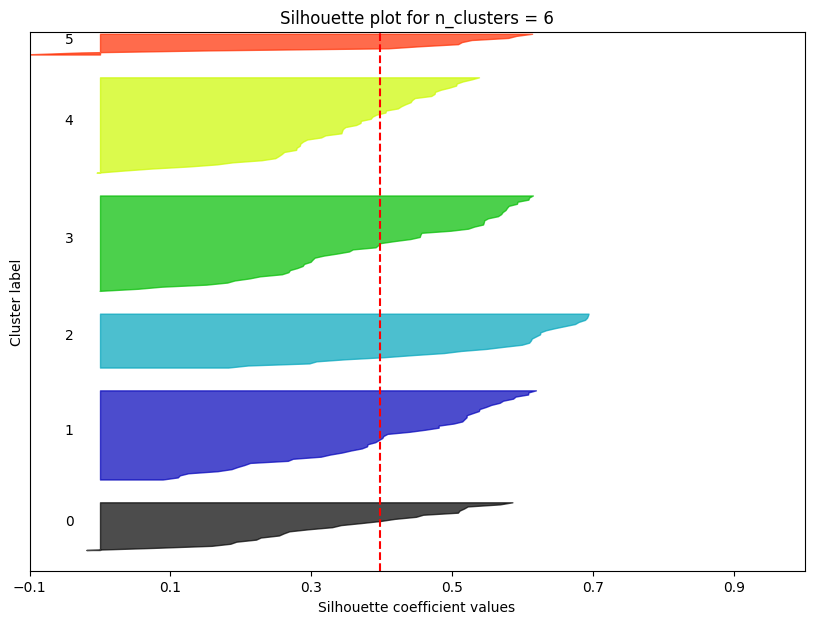

In [21]:
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples

silhouette_values_6 = silhouette_samples(reduced_features, kmeans_6.labels_)

# Create a single plot
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(10, 7)

# Silhouette plot for 6 clusters
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(scaled_features) + (5 + 1) * 10])
y_lower = 10
for i in range(6):
    ith_cluster_silhouette_values = silhouette_values_6[kmeans_6.labels_ == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / 6)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    y_lower = y_upper + 10
ax1.set_title("Silhouette plot for n_clusters = 6")
ax1.set_xlabel("Silhouette coefficient values")
ax1.set_ylabel("Cluster label")
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_yticks([])
ax1.set_xticks(np.arange(-0.1, 1.0, 0.2))

plt.show()

### Mapping the 6 Clusters back to Customers

In [33]:
customer_data_6 = customer_data.copy()
customer_data_6['Cluster'] = kmeans_6.labels_
customer_data_6['PCA1'] = reduced_features[:, 0] 
customer_data_6['PCA2'] = reduced_features[:, 1]

# Append back the customerID as the first column
customer_data_6.insert(0, 'CustomerID', customers['CustomerID']) 
customer_data_6.insert(1, 'CustomerName', customers['CustomerName'])   

customer_data_6.head()

,CustomerID,CustomerName,Tenure,Recency,Frequency,Monetary,Region_Asia,Region_Europe,Region_North America,Region_South America,Cluster,PCA1,PCA2
0,C0001,Lawrence Carroll,933,87.0,5.0,3354.52,False,False,False,True,3,0.613997,-1.694224
1,C0002,Elizabeth Lutz,1080,56.0,4.0,1862.74,True,False,False,False,4,-0.477287,-0.613687
2,C0003,Michael Rivera,327,157.0,4.0,2725.38,False,False,False,True,4,-0.483765,-1.032006
3,C0004,Kathleen Rodriguez,842,36.0,8.0,5354.88,False,False,False,True,3,2.391476,-1.219433
4,C0005,Laura Weber,897,85.0,3.0,2034.24,True,False,False,False,4,-0.933873,-0.448706


In [29]:
cluster_counts_6 = customer_data_6['Cluster'].value_counts().sort_index()
print(cluster_counts_6)

Cluster
0    24
1    44
2    27
3    47
4    47
5    11
Name: count, dtype: int64


In [45]:
# Create a scatter plot with customer names annotated
fig = px.scatter(customer_data_6, x='PCA1', y='PCA2', color='Cluster', 
                 hover_data=['CustomerID', 'CustomerName'], title='Customer Segments (K-Means, 6 Clusters)')

# Add customer ID as text annotations
for i, row in customer_data_6.iterrows():
    fig.add_annotation(x=row['PCA1'], y=row['PCA2'], text=row['CustomerID'], showarrow=False, font=dict(size=10))

fig.update_traces(marker=dict(size=12, opacity=0.9, line=dict(width=2, color='Black')))
fig.update_layout(xaxis_title='PCA Component 1', yaxis_title='PCA Component 2', width=900, height=600)
fig.show()

## Clustering for Optimal k = 4 (As per Elbow Method)

In [48]:
kmeans_4 = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans_4.fit_predict(reduced_features)

fig = px.scatter(x=reduced_features[:, 0], y=reduced_features[:, 1], color=kmeans_4.labels_, 
                 color_continuous_scale=px.colors.sequential.Viridis, 
                 title='K-Means, 4 Clusters')
fig.update_traces(marker=dict(size=12, opacity=0.9, line=dict(width=2, color='Black')))

centers_4 = kmeans_4.cluster_centers_

for i, c in enumerate(centers_4):
    fig.add_scatter(x=[c[0]], y=[c[1]], mode='markers+text', text=[f"<b>{i}</b>"], textposition='middle center', 
                    marker=dict(symbol='circle', size=24, color='white', line=dict(color='black', width=2)), showlegend=False)

fig.update_layout(xaxis_title='PCA Component 1', yaxis_title='PCA Component 2', width=900, height=600)
fig.show()

### Mapping the 4 Clusters back to Customers

In [42]:
customer_data_4 = customer_data.copy()
customer_data_4['Cluster'] = kmeans_4.labels_
customer_data_4['PCA1'] = reduced_features[:, 0] 
customer_data_4['PCA2'] = reduced_features[:, 1]

# Append back the customerID as the first column
customer_data_4.insert(0, 'CustomerID', customers['CustomerID']) 
customer_data_4.insert(1, 'CustomerName', customers['CustomerName'])   

customer_data_4.head()

,CustomerID,CustomerName,Tenure,Recency,Frequency,Monetary,Region_Asia,Region_Europe,Region_North America,Region_South America,Cluster,PCA1,PCA2
0,C0001,Lawrence Carroll,933,87.0,5.0,3354.52,False,False,False,True,3,0.613997,-1.694224
1,C0002,Elizabeth Lutz,1080,56.0,4.0,1862.74,True,False,False,False,1,-0.477287,-0.613687
2,C0003,Michael Rivera,327,157.0,4.0,2725.38,False,False,False,True,1,-0.483765,-1.032006
3,C0004,Kathleen Rodriguez,842,36.0,8.0,5354.88,False,False,False,True,3,2.391476,-1.219433
4,C0005,Laura Weber,897,85.0,3.0,2034.24,True,False,False,False,1,-0.933873,-0.448706


In [43]:
cluster_counts_4 = customer_data_4['Cluster'].value_counts().sort_index()
print(cluster_counts_4)

Cluster
0    27
1    63
2    55
3    55
Name: count, dtype: int64


In [46]:
# Create a scatter plot with customer names annotated
fig = px.scatter(customer_data_4, x='PCA1', y='PCA2', color='Cluster', 
                 hover_data=['CustomerID', 'CustomerName'], title='Customer Segments (K-Means, 4 Clusters)')

# Add customer ID as text annotations
for i, row in customer_data_4.iterrows():
    fig.add_annotation(x=row['PCA1'], y=row['PCA2'], text=row['CustomerID'], showarrow=False, font=dict(size=10))

fig.update_traces(marker=dict(size=12, opacity=0.9, line=dict(width=2, color='Black')))
fig.update_layout(xaxis_title='PCA Component 1', yaxis_title='PCA Component 2', width=900, height=600)
fig.show()